In [33]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

notification_df = pd.read_csv('../../data/notification_sequence.csv', sep = ',')
notification_df = pd.DataFrame(notification_df)

# drop '?'
notification_df = notification_df.replace('?', pd.NaT)    
notification_df = notification_df.dropna(axis=0)

# label encoding
X_categorical_col = ['gender', 'department', 'scenario']
y_categorical_col = ['tol_111111', 'tol_1122', 'tol_123', 'tol_222', 'tol_24', 'tol_15']

X = notification_df.iloc[:, :-6]
y = notification_df.iloc[:, -6:]
new = {'view_order': []}
for num, i in X.iterrows():
    # print(i['total_usetime'])
    if i['total_usetime'] == 0:
        X.drop(index = [num], inplace = True)
        y.drop(index = [num], inplace = True)
    else:
        tot = int(i['social_usetime']) + int(i['communication_usetime']) + int(i['entertainment_usetime']) + int(i['news_usetime']) + int(i['system_usetime']) + int(i['notification_usetime'])
        if tot == 0:
            X.drop(index = [num], inplace = True)
            y.drop(index = [num], inplace = True)
        else:
            i['social_usetime'] = int(i['social_usetime'])/tot
            i['communication_usetime'] = int(i['communication_usetime'])/tot
            i['entertainment_usetime'] = int(i['entertainment_usetime'])/tot
            i['news_usetime'] = int(i['news_usetime'])/tot
            i['system_usetime'] = int(i['system_usetime'])/tot
            i['notification_usetime'] = int(i['notification_usetime'])/tot
            new['view_order'].append(1 if i['view_order_top'] == 1 else (0 if i['view_order_middle'] == 1 else -1))
            
print(len(new['view_order']))
X.reset_index(drop=True, inplace=True)
X = pd.concat([X, pd.DataFrame(new)], axis=1)
X = X.drop(['view_order_top', 'view_order_middle', 'view_order_bottom'], axis=1)

labelencoder = LabelEncoder()
for i in X_categorical_col:
    X[i] = labelencoder.fit_transform(X[i])

le_name_mapping = []
for i in y_categorical_col:
    labelencoder.fit(y[i])
    le_name_mapping.append(dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_))))

# handle X with categorical in 'one-hot encode'
X = pd.get_dummies(X, columns = X_categorical_col)
print(X)

784
     age  total_usetime social_usetime communication_usetime  \
0      4              1              1                     0   
1      2              2              1                     0   
2      2              4              3                     3   
3      2              3              2                     2   
4      2              2              1                     0   
..   ...            ...            ...                   ...   
779    2              4              3                     2   
780    2              3              2                     2   
781    2              1              1                     1   
782    2              3              2                     1   
783    2              3              1                     1   

    entertainment_usetime news_usetime system_usetime notification_usetime  \
0                       0            1              0                    0   
1                       1            0              0                  

In [34]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics

def plot_confusion_matrix(confusion_mat, class_names):
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.matshow(confusion_mat, cmap=plt.cm.Greens, alpha=0.3)
    for i in range(confusion_mat.shape[0]):
        for j in range(confusion_mat.shape[1]):
            ax.text(x=j, y=i, s=format(confusion_mat[i,j], '.4f'), va='center', ha='center')
    plt.xticks(np.arange(len(class_names)), class_names)
    plt.yticks(np.arange(len(class_names)), class_names)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('Confusion Matrix\n')

def holdout_func(X, y, mod):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)
        
    print("Classification accuracy:", metrics.accuracy_score(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))

    confusion_mat = metrics.confusion_matrix(y_test, y_pred, labels=class_names)
    plot_confusion_matrix(confusion_mat, class_names)


def KFold_func(X, y, num_split, mod):
    kf = KFold(n_splits=num_split, shuffle=False)

    y_pred_sum = 0
    confusion_mat_list = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        mod.fit(X_train, y_train)
        y_pred = mod.predict(X_test)
        y_pred_sum += metrics.accuracy_score(y_test, y_pred)
        confusion_mat_list.append(metrics.confusion_matrix(y_test, y_pred, labels=class_names))
        
    print("Classification accuracy:", y_pred_sum / kf.get_n_splits(kf))
    print(metrics.classification_report(y_test, y_pred))

    mean_confusion_mat = np.mean(confusion_mat_list, axis=0)
    plot_confusion_matrix(mean_confusion_mat, class_names)

Classification accuracy: 0.0423728813559322
              precision    recall  f1-score   support

      censwy       0.00      0.00      0.00         2
      censyw       0.00      0.00      0.00         1
      cesnwy       0.00      0.00      0.00         2
      cesnyw       0.00      0.00      0.00         3
      cesynw       0.00      0.00      0.00         1
      cewsyn       0.00      0.00      0.00         1
      cnsewy       0.00      0.00      0.00         2
      cnswey       0.00      0.00      0.00         6
      cnswye       0.00      0.00      0.00         3
      cnsywe       0.00      0.00      0.00         2
      cnwsey       0.00      0.00      0.00         5
      cnwsye       0.00      0.00      0.00         2
      csenwy       0.04      0.11      0.05         9
      csenyw       0.00      0.00      0.00         1
      csewny       0.00      0.00      0.00         8
      csewyn       0.00      0.00      0.00         7
      cseynw       0.00      0.00    

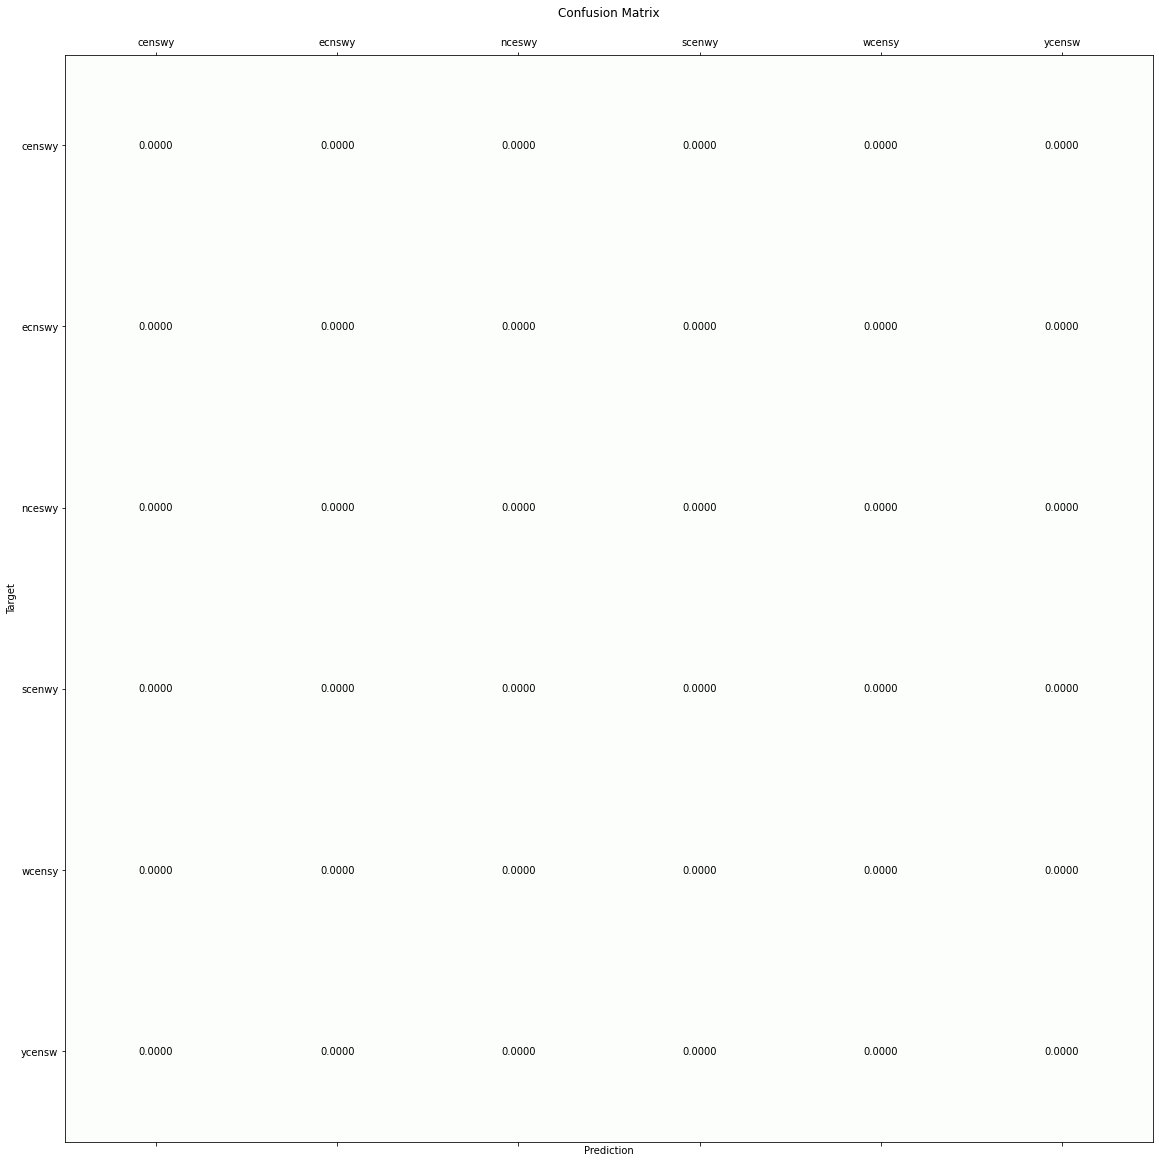

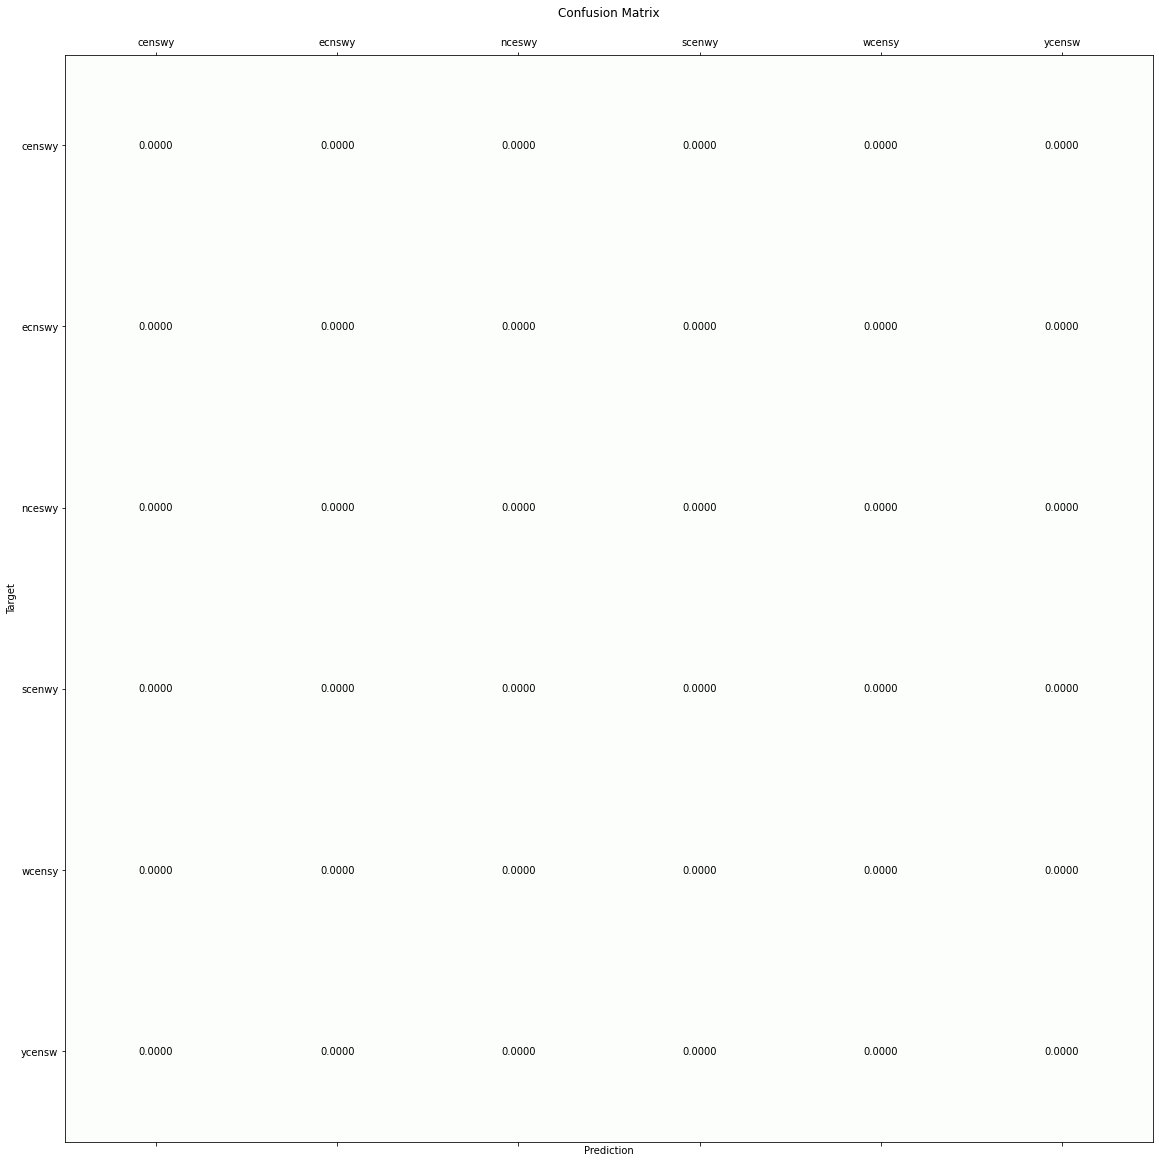

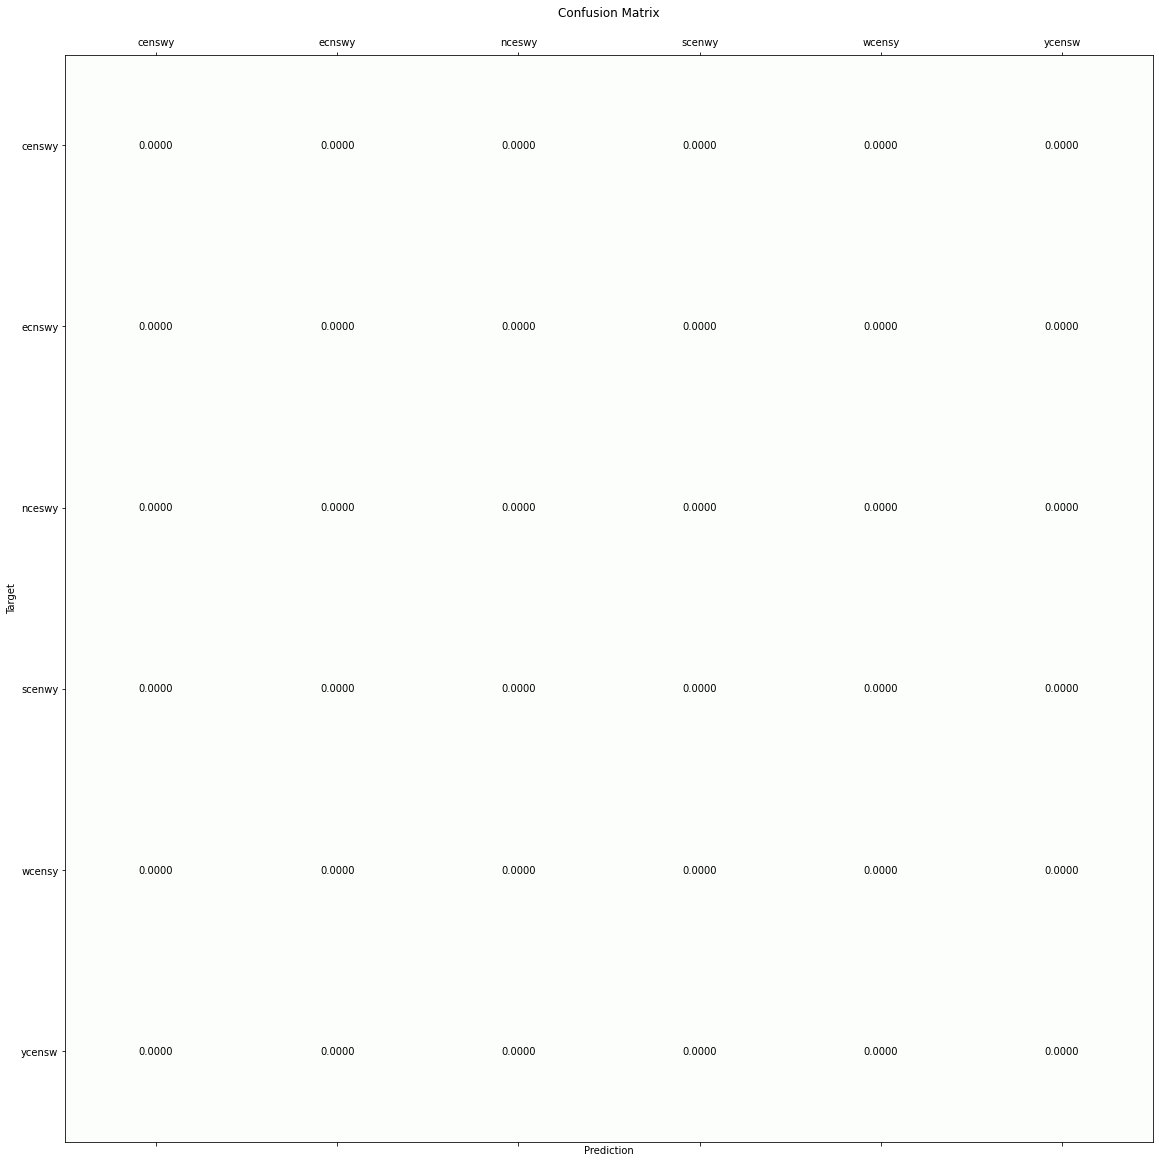

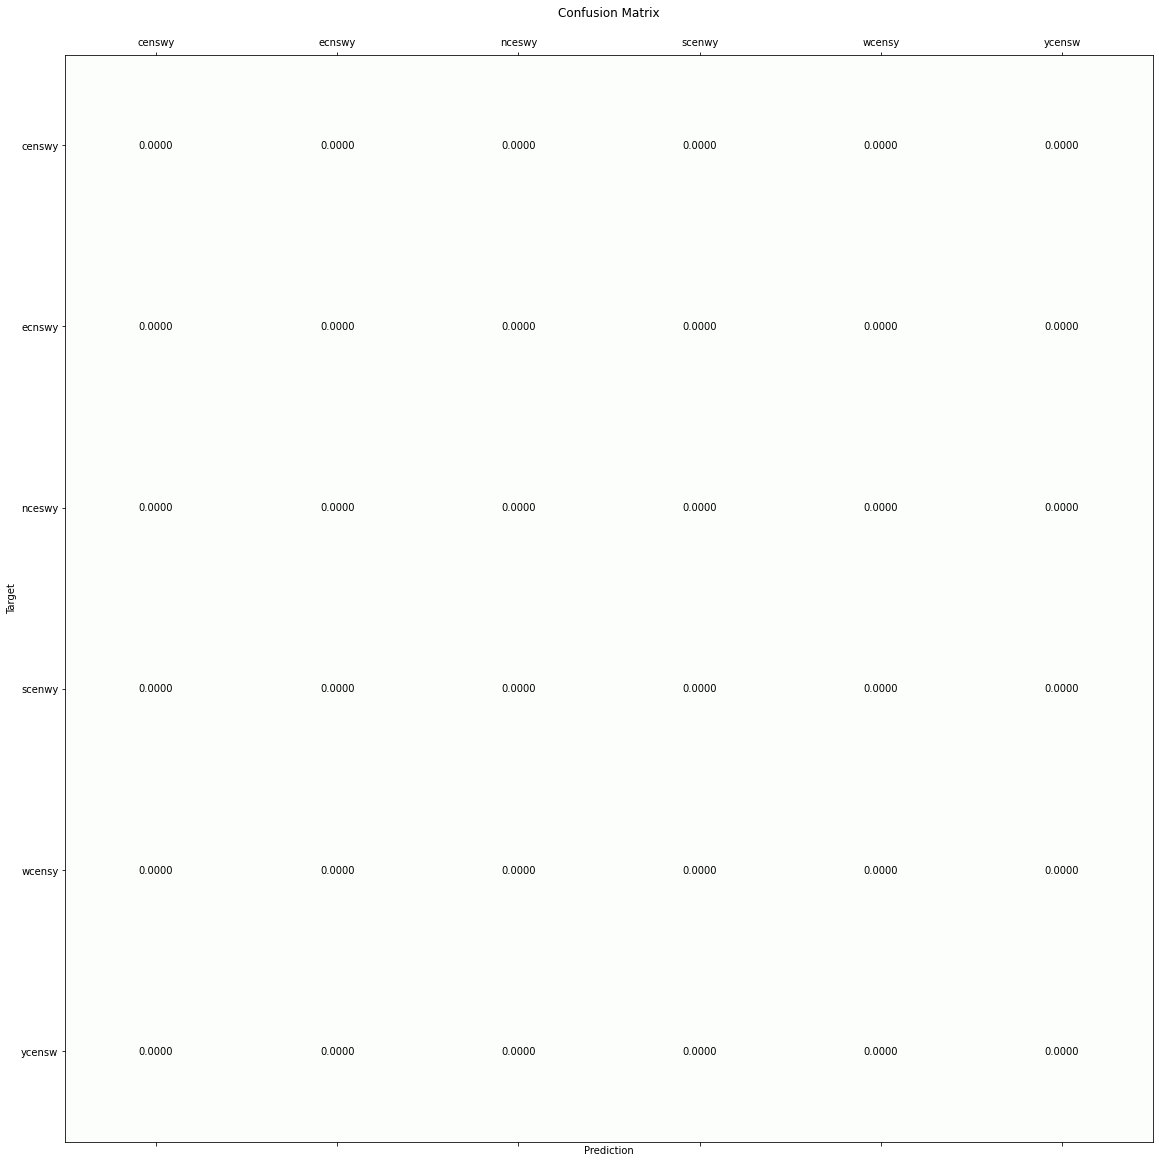

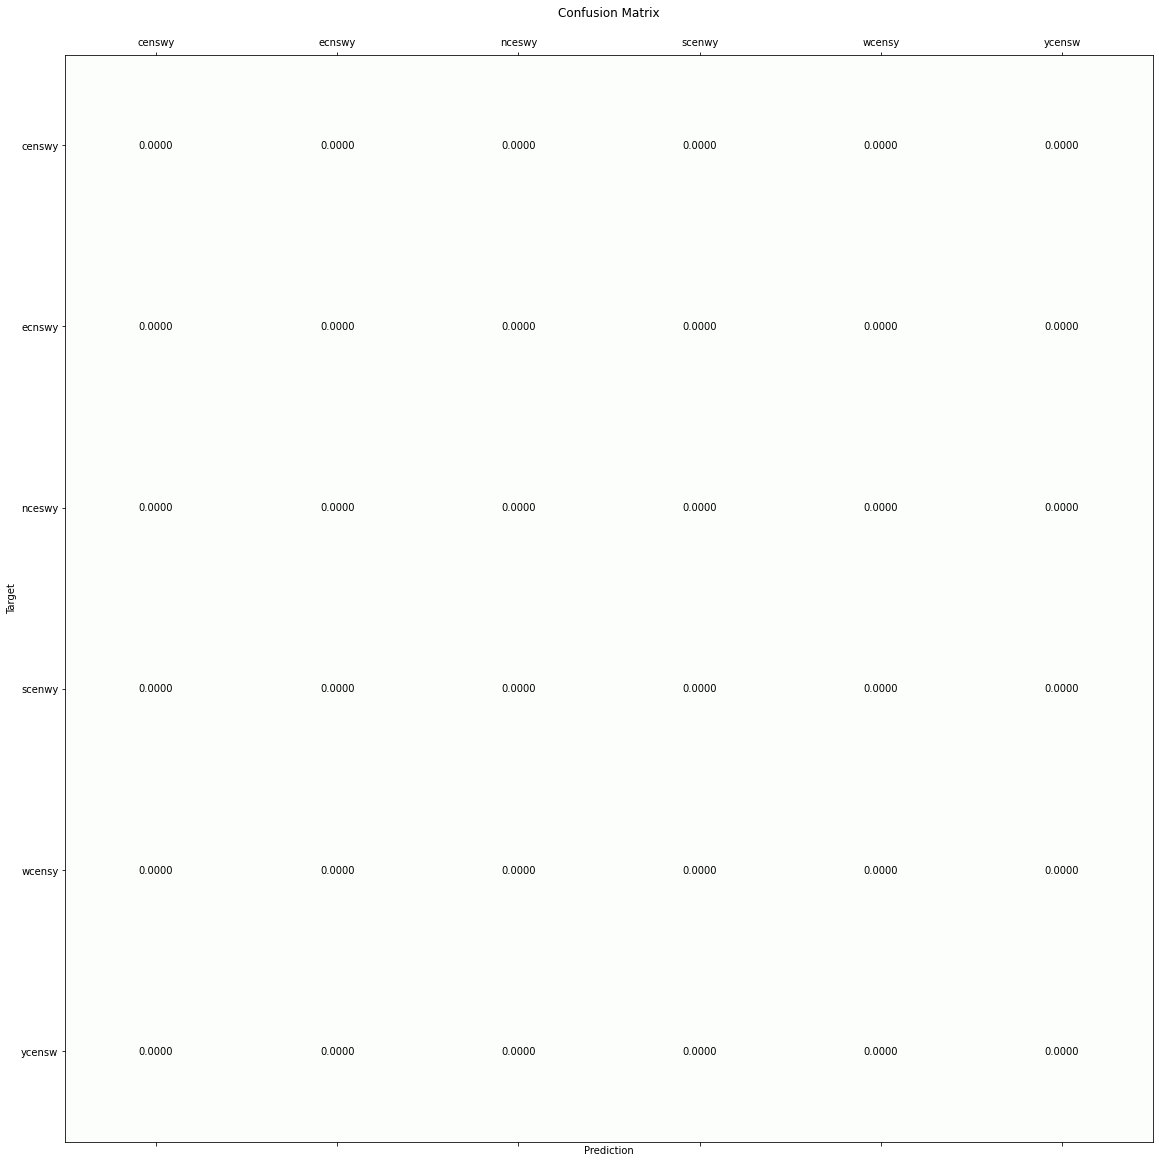

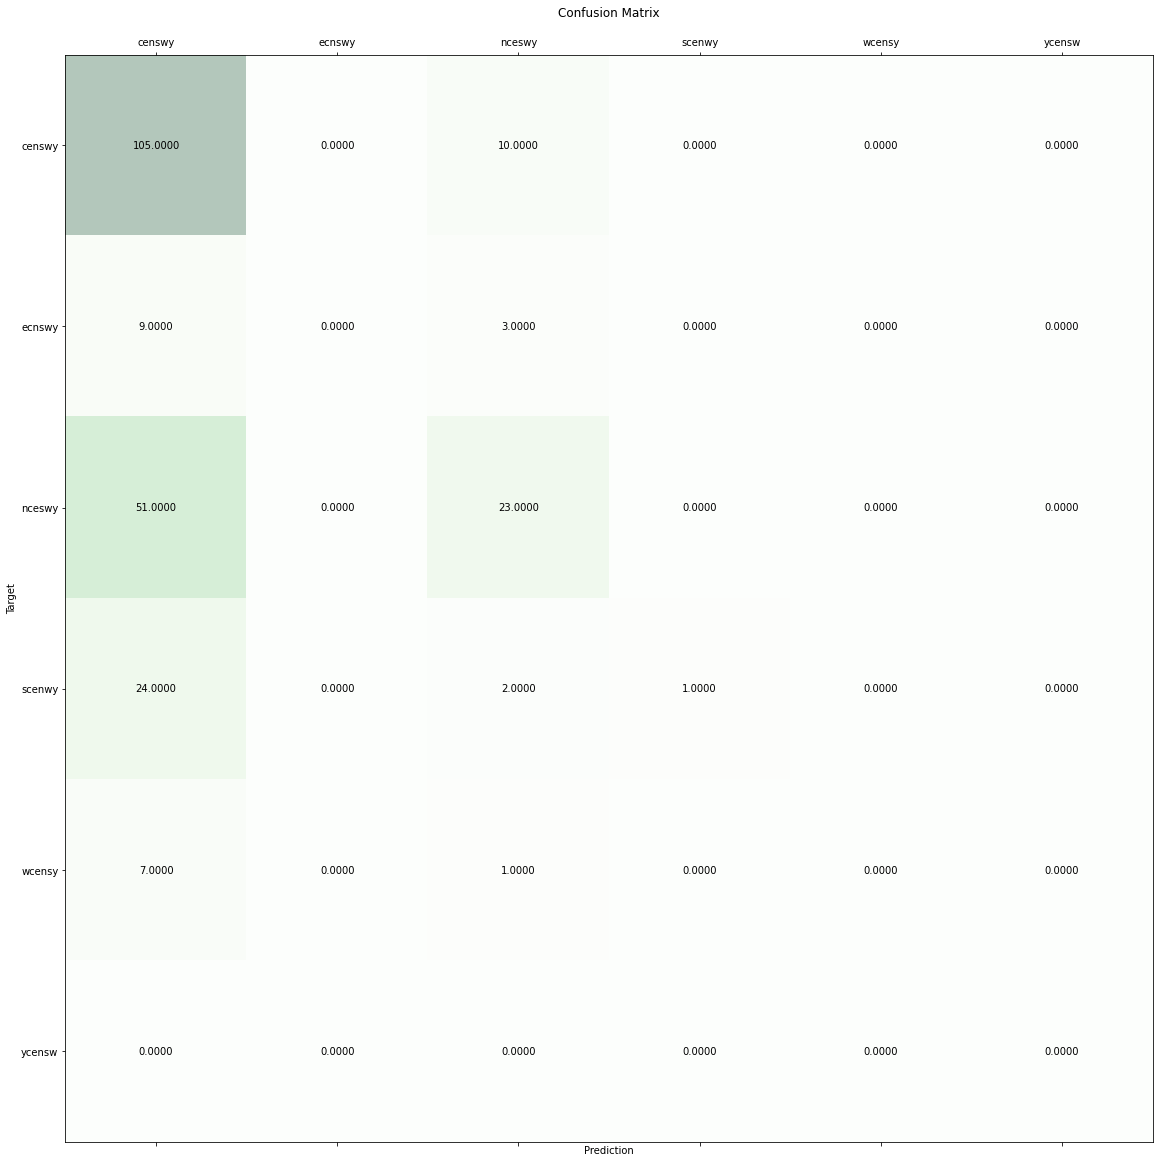

In [36]:

X = preprocessing.normalize(X)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=666)
for i in range(6):
    class_names = list(le_name_mapping[i].keys())
    holdout_func(X, y.iloc[:,i], clf)
    plt.show

